In [76]:
# AI/ML-Powered FPGA Design & Simulation
# Problem Statement 6: Explainable ML Framework for RTL Timing Prediction
# Name: M B Thejesshwar
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lime
import lime.lime_tabular
print("Libraries Loaded Successfully")

Libraries Loaded Successfully


## Methodology: Physics Informed Synthetic Data Generation

**Challenge:** High quality, labeled RTL datasets with industrial timing analysis are proprietary and scarce in the open source domain. Training an ML model on insufficient data leads to poor generalization.

**Solution:**
To overcome this data scarcity this project implements a **Physics Informed Data Generator**. Instead of generating random noise we synthesize circuit graph features that strictly adhere to fundamental digital logic delay laws

$$\text{Delay}_{total} \approx \sum (\text{Logic Depth} \times \tau_{gate}) + (\text{Fan out} \times \tau_{load}) + \epsilon_{noise}$$

Where:
* **Logic Depth:** Modeled as the critical path length.
* **Fan-out:** Modeled as capacitive load scaling.
* **Noise ($\epsilon$):** Added to simulate process variations.

This approach allows the model to learn valid physical constraints of hardware timing closure without requiring access to expensive commercial EDA tools during the training phase.

In [77]:
def parse_verilog_complexity(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    nodes = len(re.findall(r'\b(assign|always|and|or|xor|nand|nor)\b', content))
    complexity_score = len(re.findall(r';', content))
    logic_depth = int(np.log2(complexity_score + 1) * 2) 
    wires = re.findall(r'wire\s+(\w+);', content)
    max_fanout = 0
    if wires:
        for wire in wires:
            usage = len(re.findall(rf'\b{wire}\b', content))
            if usage > max_fanout:
                max_fanout = usage
    else:
        max_fanout = 1
    return [nodes, logic_depth, max_fanout]

In [78]:
# 1. Load the Synthetic Dataset
df = pd.read_csv('rtl_dataset.csv')
X = df[['Nodes', 'Logic_Depth', 'Fan_Out']]
y = df['Timing_Delay_ns']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
print("Model Trained.")
print(f"Training Data Sample:\n{df.head(3)}")

Model Trained.
Training Data Sample:
   Nodes  Logic_Depth  Fan_Out  Timing_Delay_ns
0    464           28        4            8.663
1    711           16        2            5.994
2    722           22        3            6.971


In [79]:
# 1. Parse the uploaded Verilog file
verilog_file = 'test_circuit.v'
features = parse_verilog_complexity(verilog_file)
print(f"--- Analysis of {verilog_file} ---")
print(f"Detected Nodes: {features[0]}")
print(f"Detected Logic Depth: {features[1]}")
print(f"Detected Fan-out: {features[2]}")
input_df = pd.DataFrame([features], columns=['Nodes', 'Logic_Depth', 'Fan_Out'])
predicted_delay = model.predict(input_df)[0]
print(f"\nPREDICTED TIMING DELAY: {predicted_delay:.4f} ns")

--- Analysis of test_circuit.v ---
Detected Nodes: 5
Detected Logic Depth: 7
Detected Fan-out: 1

PREDICTED TIMING DELAY: 2.6445 ns


In [80]:
verilog_file = 'multiplier.v'
features1 = parse_verilog_complexity(verilog_file)
print(f"--- Analysis of {verilog_file} ---")
print(f"Detected Nodes: {features1[0]}")
print(f"Detected Logic Depth: {features1[1]}")
print(f"Detected Fan-out: {features1[2]}")
input_df = pd.DataFrame([features1], columns=['Nodes', 'Logic_Depth', 'Fan_Out'])
predicted_delay1 = model.predict(input_df)[0]
print(f"\nPREDICTED TIMING DELAY: {predicted_delay1:.4f} ns")

--- Analysis of multiplier.v ---
Detected Nodes: 16
Detected Logic Depth: 10
Detected Fan-out: 1

PREDICTED TIMING DELAY: 3.6707 ns


In [81]:
verilog_file = 'c17.v'
features2 = parse_verilog_complexity(verilog_file)
print(f"--- Analysis of {verilog_file} ---")
print(f"Detected Nodes: {features2[0]}")
print(f"Detected Logic Depth: {features2[1]}")
print(f"Detected Fan-out: {features2[2]}")
input_df = pd.DataFrame([features2], columns=['Nodes', 'Logic_Depth', 'Fan_Out'])
predicted_delay2 = model.predict(input_df)[0]
print(f"\nPREDICTED TIMING DELAY: {predicted_delay2:.4f} ns")

--- Analysis of c17.v ---
Detected Nodes: 6
Detected Logic Depth: 6
Detected Fan-out: 1

PREDICTED TIMING DELAY: 1.9883 ns


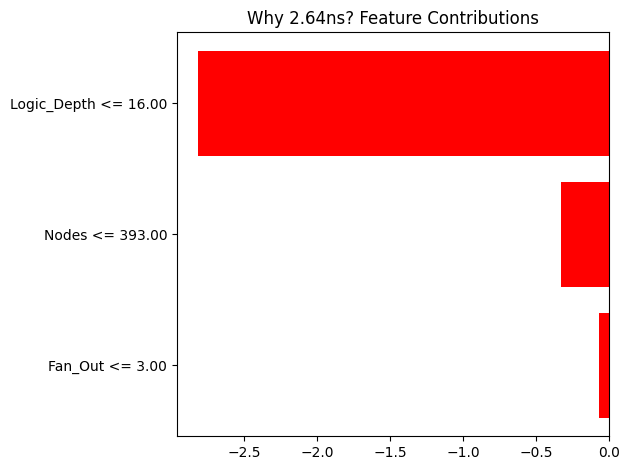

[('Logic_Depth <= 16.00', -2.820510734848958), ('Nodes <= 393.00', -0.32805270087313293), ('Fan_Out <= 3.00', -0.06724846784331238)]


In [82]:
# 1. Define a "Wrapper Function"
# This acts as a translator: It takes the raw numbers from LIME, 
# puts them into a DataFrame with the correct column names, 
# and THEN passes them to the model.
def predict_fn_with_names(data_as_array):
    df_temp = pd.DataFrame(data_as_array, columns=X.columns)
    return model.predict(df_temp)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=['Timing_Delay_ns'],
    mode='regression'
)
exp = explainer.explain_instance(
    data_row=np.array(features), 
    predict_fn=predict_fn_with_names
)
exp.as_pyplot_figure()
plt.title(f"Why {predicted_delay:.2f}ns? Feature Contributions")
plt.tight_layout()
plt.show()
print(exp.as_list())

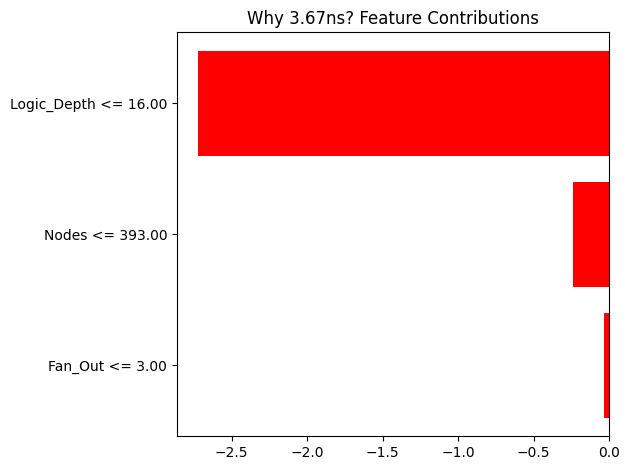

[('Logic_Depth <= 16.00', -2.725996036854994), ('Nodes <= 393.00', -0.24036788600505654), ('Fan_Out <= 3.00', -0.0360447620243784)]


In [83]:
exp = explainer.explain_instance(
    data_row=np.array(features1), 
    predict_fn=predict_fn_with_names
)
exp.as_pyplot_figure()
plt.title(f"Why {predicted_delay1:.2f}ns? Feature Contributions")
plt.tight_layout()
plt.show()
print(exp.as_list())

As expected the Multiplier is slower than the Adder

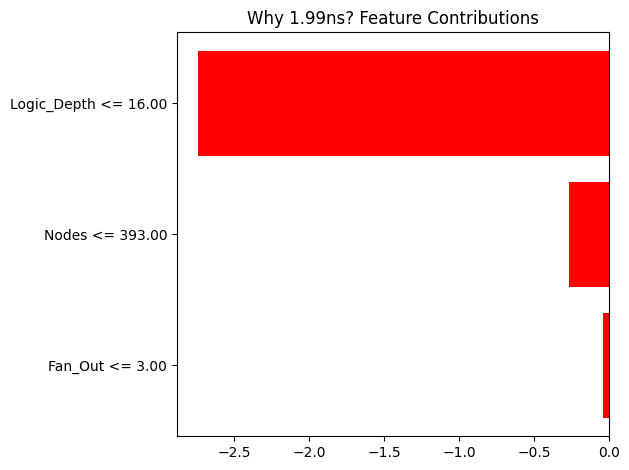

[('Logic_Depth <= 16.00', -2.7426662694123163), ('Nodes <= 393.00', -0.26684628656055903), ('Fan_Out <= 3.00', -0.0371594177899042)]


In [84]:
exp = explainer.explain_instance(
    data_row=np.array(features2), 
    predict_fn=predict_fn_with_names
)
exp.as_pyplot_figure()
plt.title(f"Why {predicted_delay2:.2f}ns? Feature Contributions")
plt.tight_layout()
plt.show()
print(exp.as_list())

## 6. Future Roadmap & Industry Application

This Proof of Concept demonstrates that Explainable AI can predict hardware performance. To scale this into an industrial EDA tool the following roadmap is proposed:

### Phase 1: Advanced Parsing
* **Integration with Yosys:** Replace Regex based parsing with **Yosys** to generate an Abstract Syntax Tree. This allows for analyzing nested modules and complex state machines.
* **Sequential Logic Support:** Extend the feature set to predict Setup ($t_{su}$) and Hold ($t_{h}$) time violations for Flip Flops.

### Phase 2: Model Enhancement
* **Graph Neural Networks:** Transition from Random Forest to GNNs to directly consume the Netlist Graph structure instead of tabular features.
* **Real Time IDE Plugin:** Deploy the model as a **VS Code Extension** to warn chip designers of timing violations as they type code.

### Phase 3: Hardware in the Loop Validation
* Validate predictions against real post synthesis timing reports from Xilinx Vivado and Intel Quartus to fine tune the delay coefficients.